In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/CFL_training_data"

In [5]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(data_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

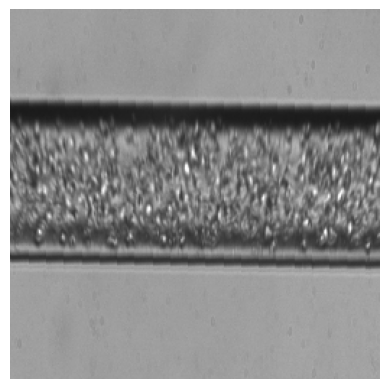

(256, 256, 3)


In [6]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

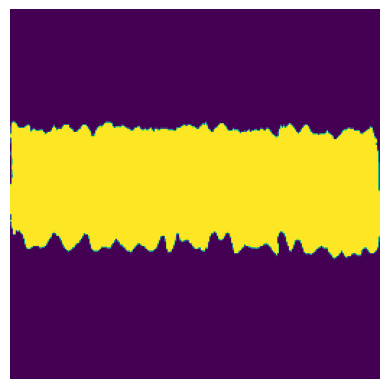

(256, 256, 1)


In [7]:
plt.imshow(output_images[1]*255)
plt.axis('off')
plt.show()
print(output_images[1].shape)

In [8]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [9]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.3)(p)
   return f, p

In [10]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [11]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.layers import add, multiply



def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def attention_block(g, x, num_filters):
    """
    g - output of the previous layer
    x - skip connection from the encoder
    num_filters - number of filters
    """
    F_g = Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(g)
    F_x = Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(x)
    F_int = add([F_g, F_x])
    F_int = Activation('relu')(F_int)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(F_int)
    return multiply([x, psi])



def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    skip_features = attention_block(x, skip_features, num_filters)  # Apply attention
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



def build_unet_with_attention(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net-with-Attention")
    return model


In [12]:
unet_model = build_unet_with_attention((256, 256, 3), 1)

In [13]:
unet_model.summary()

Model: "U-Net-with-Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_nor

In [14]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [15]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [16]:
np.array(output_images).shape



(1000, 256, 256, 1)

In [17]:
checkpoint_filepath = os.path.join(data_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [18]:
unet_model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Epoch 1/30
100/100 [==============================] - 100s 594ms/step - loss: 0.1277 - dice_coef: 0.8581 - binary_accuracy: 0.9471 - true_positive_rate: 0.9714 - val_loss: 0.6109 - val_dice_coef: 0.4303 - val_binary_accuracy: 0.5810 - val_true_positive_rate: 0.0683
Epoch 2/30
100/100 [==============================] - 61s 614ms/step - loss: 0.0692 - dice_coef: 0.9163 - binary_accuracy: 0.9626 - true_positive_rate: 0.9749 - val_loss: 0.1302 - val_dice_coef: 0.8919 - val_binary_accuracy: 0.9587 - val_true_positive_rate: 0.9853
Epoch 3/30
100/100 [==============================] - 69s 689ms/step - loss: 0.0596 - dice_coef: 0.9282 - binary_accuracy: 0.9636 - true_positive_rate: 0.9784 - val_loss: 0.1712 - val_dice_coef: 0.8701 - val_binary_accuracy: 0.9420 - val_true_positive_rate: 0.9855
Epoch 4/30
100/100 [==============================] - 69s 691ms/step - loss: 0.0544 - dice_coef: 0.9351 - binary_accuracy: 0.9640 - true_positive_rate: 0.9794 - val_loss: 0.4320 - val_dice_coef: 0.7801 - 

In [19]:
unet_model.save(os.path.join(data_path, 'final_model_30_ep.hdf5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
np.array(input_images[:5]).shape

(5, 256, 256, 3)

In [21]:
pred = unet_model.predict(np.array(input_images[:5]))

1/1 [==============================] - 8s 8s/step


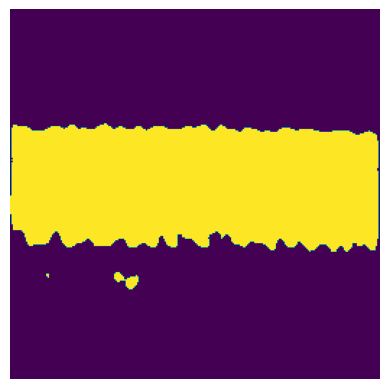

In [28]:
plt.imshow(pred[1]>0.79)
plt.axis('off')
plt.show()

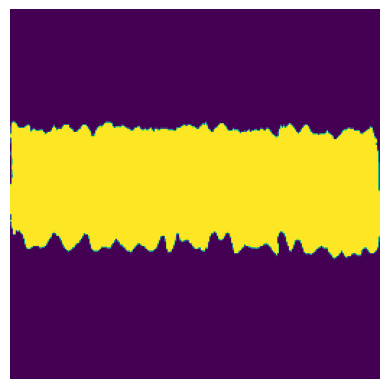

In [29]:
plt.imshow(output_images[1])
plt.axis('off')
plt.show()